In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Double Elements Regression

In [4]:
times = 10000

In [5]:
def init_y():
    for i in total_rain:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_rdt[i] = rdt[0]


def init():
    init_y()
    return init_list()


def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE


def predict_n(n, times):
    if n == 0:
        return predict_zero(), 0.0

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(2 * n)])
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times


def test_degree_n(times):
    degree = np.linspace(start, end, end-start+1)
    for i in degree:
        rRMSE_degree[crop + i.astype(int).astype(str)], coeffs[crop + i.astype(int).astype(str)] = predict_n(i.astype(int), times)


def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(start, end + 1, 1))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(start, end, end-start+1)
        for i in range(start, end - start + 1):
            rRMSE_plot.append(rRMSE_degree[crop + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

## rr24 + DJ_0

In [6]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rain = 0
                rad_0 = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rain += data_station["rr24"][k]
                        rad_0 += data_station["DJ_0"][k]
                    else:
                        year_position = k
                        break
                total_rain[str(provinces[i]) + "_" + str(j)] = rain
                total_rad_0[str(provinces[i]) + "_" + str(j)] = rad_0

def init_list():
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i in total_rain:
            data_list.append(np.array([total_rain[i], total_rad_0[i]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [7]:
start = 0
end = 10

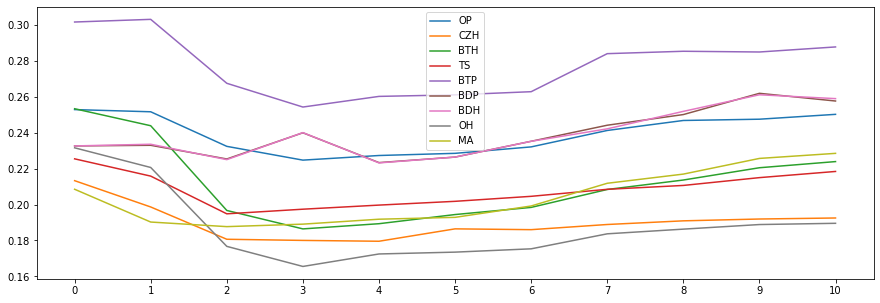

In [8]:
rRMSE_degree = {}
total_rain = {}
total_rad_0 = {}
coeffs = {}
init_x()

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()

    test_degree_n(times)

draw()

In [9]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP3': 0.22476032942113744,
 'CZH4': 0.1795404994136586,
 'BTH3': 0.18642733264321829,
 'TS2': 0.19483209254866318,
 'BTP3': 0.2543526465261086,
 'BDP4': 0.2233759389195416,
 'BDH4': 0.22321385040539052,
 'OH3': 0.16549722688803084,
 'MA2': 0.18768841496211303}

In [10]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP3': array([ 7.57990693e-08, -8.08017109e-10, -1.93654183e-04,  7.46636616e-06,
         1.47239403e-01, -2.28871313e-02]),
 'CZH4': array([-3.75452389e-11, -1.26907897e-13,  1.35574859e-07,  1.32425456e-09,
        -1.81003947e-04, -4.05328127e-06,  1.03285406e-01,  8.17947243e-05]),
 'BTH3': array([ 1.11517229e-07, -1.00983974e-09, -2.87199681e-04,  8.09153282e-06,
         2.24422859e-01, -2.28259274e-02]),
 'TS2': array([-1.88393831e-05, -4.70207961e-07,  3.07402917e-02,  6.20830551e-04]),
 'BTP3': array([ 1.48654771e-07, -1.36417261e-09, -3.66413346e-04,  1.20801738e-05,
         2.66684311e-01, -3.43958472e-02]),
 'BDP4': array([ 3.51244516e-11, -6.64261631e-13, -7.52711062e-08,  8.11866622e-09,
         1.77161017e-05, -3.13500683e-05,  3.70859029e-02,  3.66273294e-02]),
 'BDH4': array([ 3.57115569e-11, -6.62919740e-13, -7.70844541e-08,  8.10098975e-09,
         1.96953910e-05, -3.12794916e-05,  3.62213336e-02,  3.65587366e-02]),
 'OH3': array([ 9.54059577e-08, -9.01769441e-1

## rr24 + DJ_6

In [11]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rain = 0
                rad_6 = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rain += data_station["rr24"][k]
                        rad_6 += data_station["DJ_6"][k]
                    else:
                        year_position = k
                        break
                total_rain[str(provinces[i]) + "_" + str(j)] = rain
                total_rad_6[str(provinces[i]) + "_" + str(j)] = rad_6

def init_list():
    data_list = []
    rdt_list = []

    for i in total_rdt:
        if i in total_rain:
            data_list.append(np.array([total_rain[i], total_rad_6[i]]))
            rdt_list.append(total_rdt[i])

    data_list = np.array(data_list)
    rdt_list = np.array(rdt_list)
    
    return data_list, rdt_list

In [12]:
start = 0
end = 10

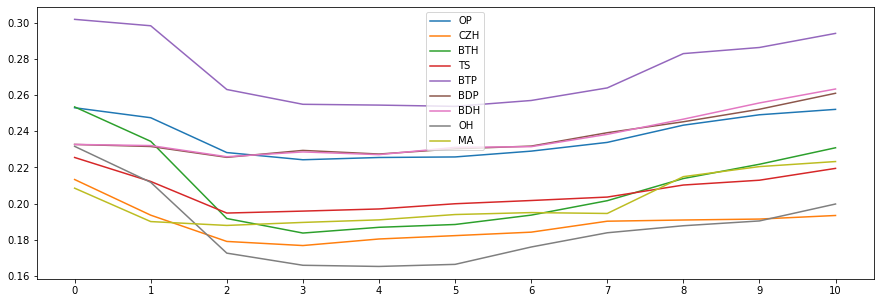

In [13]:
rRMSE_degree = {}
total_rain = {}
total_rad_6 = {}
coeffs = {}
init_x()

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init()

    test_degree_n(times)

draw()

In [14]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(end - start + 1):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP3': 0.2242189415126233,
 'CZH3': 0.17684561772530968,
 'BTH3': 0.18374600000455307,
 'TS2': 0.19478518594703412,
 'BTP5': 0.2537015815090484,
 'BDP2': 0.22555339746590822,
 'BDH2': 0.22589179292412642,
 'OH4': 0.16530291725530594,
 'MA2': 0.18795377953458603}

In [15]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP3': array([ 6.48656626e-08, -1.75266514e-09, -1.70659744e-04,  9.19083664e-06,
         1.33069202e-01, -1.81431542e-02]),
 'CZH3': array([ 3.60167932e-08, -6.22740928e-10, -9.57969454e-05,  3.67570063e-06,
         7.78694839e-02, -1.13972029e-02]),
 'BTH3': array([ 9.99233962e-08, -1.89148508e-09, -2.64449453e-04,  7.81928153e-06,
         2.11537565e-01, -1.62716543e-02]),
 'TS2': array([-1.89571360e-05, -4.28222411e-07,  3.04158113e-02, -2.14045909e-03]),
 'BTP5': array([-3.19312513e-13,  2.07115091e-15,  1.20120101e-09, -1.90993130e-11,
        -1.51287379e-06,  5.75414702e-08,  6.59579055e-04, -6.01883332e-05,
         2.80062684e-06,  6.60219406e-07]),
 'BDP2': array([-2.35454210e-05, -1.25835190e-06,  3.60473783e-02,  2.69828491e-04]),
 'BDH2': array([-2.36396193e-05, -1.25389815e-06,  3.62090512e-02,  2.39843326e-04]),
 'OH4': array([-5.32400606e-11,  2.23702718e-12,  2.42229675e-07, -2.07334985e-08,
        -3.79877702e-04,  6.10629785e-05,  2.38224901e-01, -7.18223549e-0